In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from numba import cuda, jit, int32, int64
from math import ceil
from time import time

# Чтение и начальная обработка изображения

In [52]:
img = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)
print("Image Properties")
print("- Number of Pixels: " + str(img.size))
print("- Shape/Dimensions: " + str(img.shape))

Image Properties
- Number of Pixels: 75000
- Shape/Dimensions: (250, 300)


## Реализация на CPU

In [4]:
def make_zeros(number):
    return [0] * number

Далее реализована функция, которая войдет в основу кода для GPU. В функцию на вход подается начальное изображение в градациях серого, его копия по размеру, чувствительность фильтра (значение 1 - для минимального вмешательства фильтра, и 255 - для максимального размытия), а также размер пикселя. 

In [5]:
def bileteral (img, B, d):
  post_img = []
  for row in img:
    post_img.append(make_zeros(len(img[0])))
    
  for x in range(d, img.shape[0] - d):
    for y in range(d, img.shape[1] - d):
      sum = 0
      count = 0
      for i in range(x-d, x+d):
        for j in range(y-d, y+d):
          if abs(img[x][y]-img[i][j]) < B:
            sum += img[i][j]
            count+=1
          
      res = sum / count
      post_img[x][y] = int(res)

  for x in range(d):
    for h in range(len(img)):
      post_img[h][x] = img[h][x]
      post_img[h][-x-1] = img[h][-x-1]
    for w in range(len(img[0])):
      post_img[x][w] = img[x][w]
      post_img[-x-1][w] = img[-x-1][w]

  return post_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  if sys.path[0] == '':


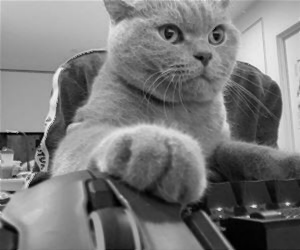

In [60]:
test_cpu = np.array(bileteral(img, 150, 1))
cv2_imshow(test_cpu)

# Реализация на GPU

In [71]:
def DeviceHost(img, B, d):
  post_img = []
  for row in img:
    post_img.append(make_zeros(len(img[0])))
  
  help = [B, d]

  dev_img = cuda.to_device(img)
  dev_pimg = cuda.to_device(post_img)
  dev_help = cuda.to_device(help)

  block = (32, 32)
  blockgrid = (ceil(img.shape[0]/block[0]), ceil(img.shape[1]/block[1]))

  Bileteral_cuda[blockgrid, block](dev_img, dev_pimg, dev_help)

  tmp = dev_pimg.copy_to_host()
  
  for x in range(d):
    for h in range(len(img)):
      tmp[h][x] = img[h][x]
      tmp[h][-x-1] = img[h][-x-1]
    for w in range(len(img[0])):
      tmp[x][w] = img[x][w]
      tmp[-x-1][w] = img[-x-1][w]
  
  return tmp

In [54]:
@cuda.jit
def Bileteral_cuda(img, pimg, H):
  idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  jdx = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  if idx < (img.shape[0])-(H[1]*2) and (jdx < img.shape[1])-(H[1]*2):
    x = idx + H[1]
    y = jdx + H[1]
    sum = 0
    count = 0
    for i in range(x-H[1], x+H[1]):
      for j in range(y-H[1], y+H[1]): 
        if abs(img[x][y] - img[i][j]) < H[0]:
          sum +=img[i][j]
          count+=1
    pimg[x][y] = sum / count

(8, 10)


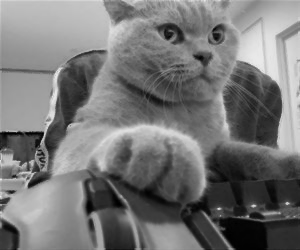

In [62]:
test = DeviceHost(img, 100, 2)
cv2_imshow(test)

# Research

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  if sys.path[0] == '':


Result CPU for B = 1 and d = 1:
Performing CPU time 1.3287129402160645
Visualization CPU:


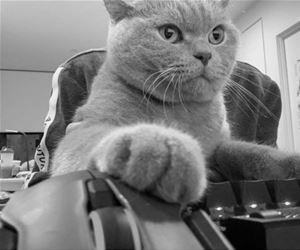

Result GPU for B = 1 and d = 1:
Performing GPU time 0.015810489654541016
Visualization GPU:


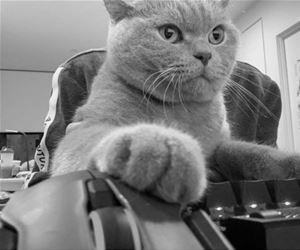


Result CPU for B = 1 and d = 2:
Performing CPU time 4.2393834590911865
Visualization CPU:


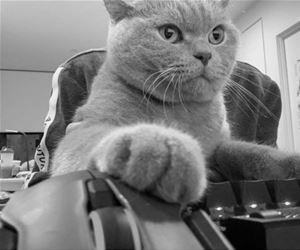

Result GPU for B = 1 and d = 2:
Performing GPU time 0.013933897018432617
Visualization GPU:


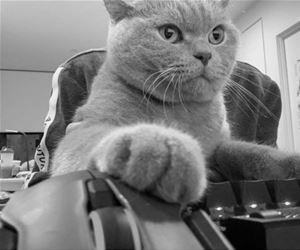


Result CPU for B = 1 and d = 3:
Performing CPU time 9.079757928848267
Visualization CPU:


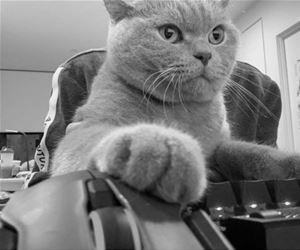

Result GPU for B = 1 and d = 3:
Performing GPU time 0.020177364349365234
Visualization GPU:


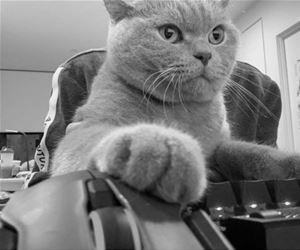


Result CPU for B = 51 and d = 1:
Performing CPU time 1.3788654804229736
Visualization CPU:


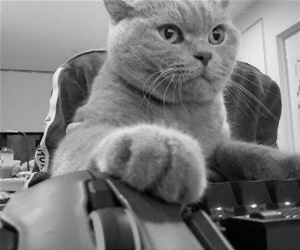

Result GPU for B = 51 and d = 1:
Performing GPU time 0.016419172286987305
Visualization GPU:


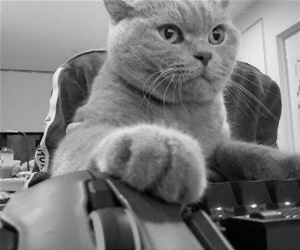


Result CPU for B = 51 and d = 2:
Performing CPU time 4.646459341049194
Visualization CPU:


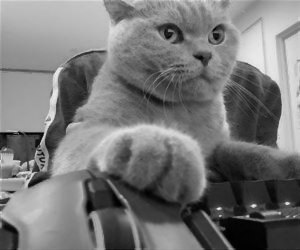

Result GPU for B = 51 and d = 2:
Performing GPU time 0.017477035522460938
Visualization GPU:


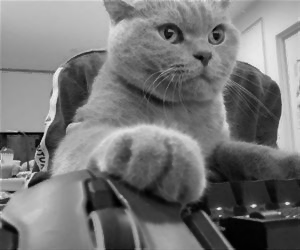


Result CPU for B = 51 and d = 3:
Performing CPU time 9.685561418533325
Visualization CPU:


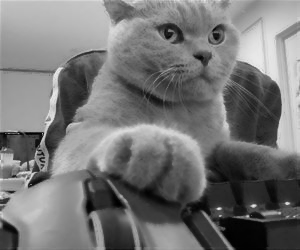

Result GPU for B = 51 and d = 3:
Performing GPU time 0.019544363021850586
Visualization GPU:


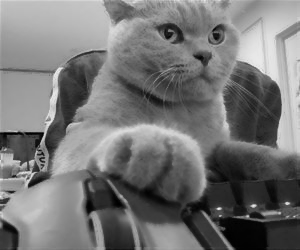


Result CPU for B = 101 and d = 1:
Performing CPU time 1.3795650005340576
Visualization CPU:


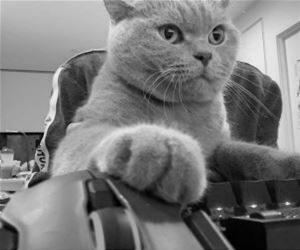

Result GPU for B = 101 and d = 1:
Performing GPU time 0.014974355697631836
Visualization GPU:


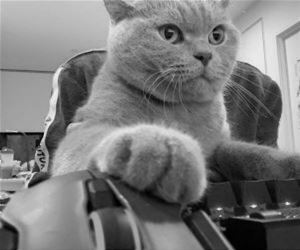


Result CPU for B = 101 and d = 2:
Performing CPU time 4.511444568634033
Visualization CPU:


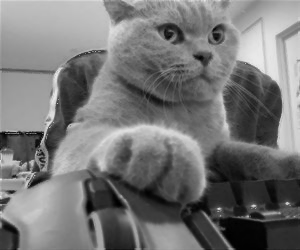

Result GPU for B = 101 and d = 2:
Performing GPU time 0.023873090744018555
Visualization GPU:


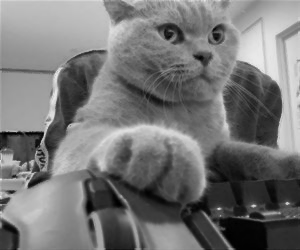


Result CPU for B = 101 and d = 3:
Performing CPU time 9.805748462677002
Visualization CPU:


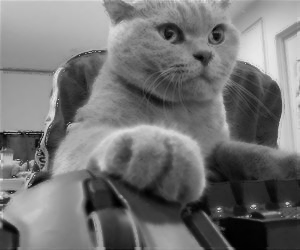

Result GPU for B = 101 and d = 3:
Performing GPU time 0.030422210693359375
Visualization GPU:


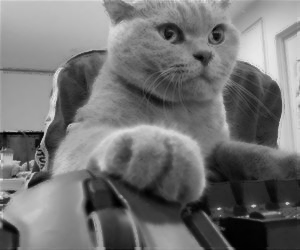


Result CPU for B = 151 and d = 1:
Performing CPU time 1.3809642791748047
Visualization CPU:


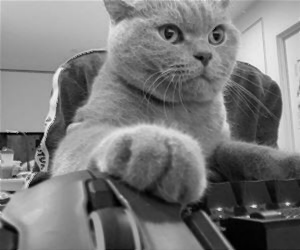

Result GPU for B = 151 and d = 1:
Performing GPU time 0.01708197593688965
Visualization GPU:


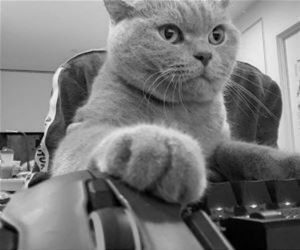


Result CPU for B = 151 and d = 2:
Performing CPU time 4.607864618301392
Visualization CPU:


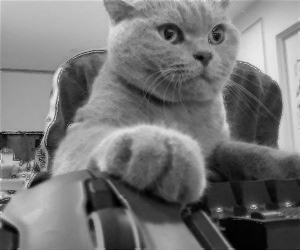

Result GPU for B = 151 and d = 2:
Performing GPU time 0.01719808578491211
Visualization GPU:


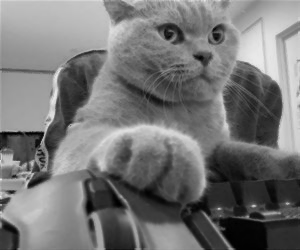


Result CPU for B = 151 and d = 3:
Performing CPU time 9.743099212646484
Visualization CPU:


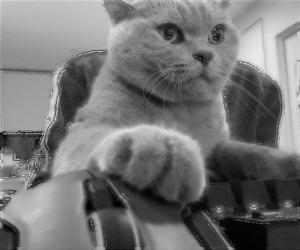

Result GPU for B = 151 and d = 3:
Performing GPU time 0.02069878578186035
Visualization GPU:


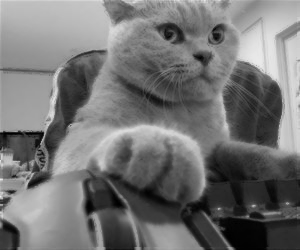


Result CPU for B = 201 and d = 1:
Performing CPU time 1.4217171669006348
Visualization CPU:


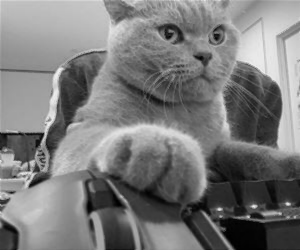

Result GPU for B = 201 and d = 1:
Performing GPU time 0.02032160758972168
Visualization GPU:


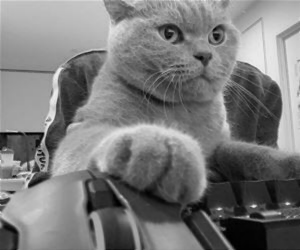


Result CPU for B = 201 and d = 2:
Performing CPU time 4.6071836948394775
Visualization CPU:


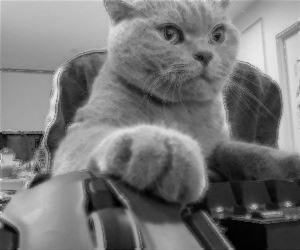

Result GPU for B = 201 and d = 2:
Performing GPU time 0.01821160316467285
Visualization GPU:


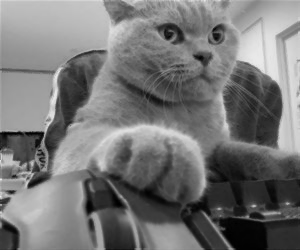


Result CPU for B = 201 and d = 3:
Performing CPU time 9.95868468284607
Visualization CPU:


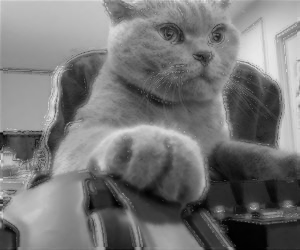

Result GPU for B = 201 and d = 3:
Performing GPU time 0.021846294403076172
Visualization GPU:


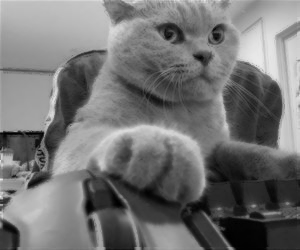


Result CPU for B = 251 and d = 1:
Performing CPU time 1.4801216125488281
Visualization CPU:


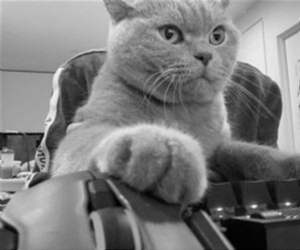

Result GPU for B = 251 and d = 1:
Performing GPU time 0.01920294761657715
Visualization GPU:


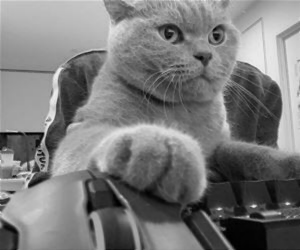


Result CPU for B = 251 and d = 2:
Performing CPU time 4.8769690990448
Visualization CPU:


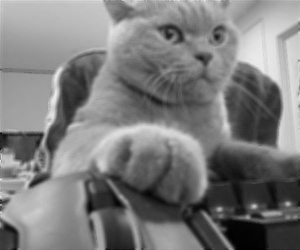

Result GPU for B = 251 and d = 2:
Performing GPU time 0.024120807647705078
Visualization GPU:


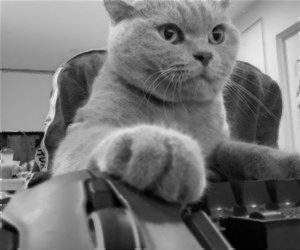


Result CPU for B = 251 and d = 3:
Performing CPU time 10.192989826202393
Visualization CPU:


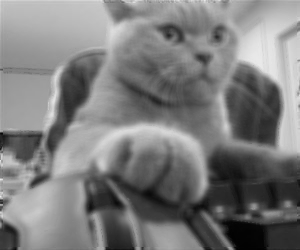

Result GPU for B = 251 and d = 3:
Performing GPU time 0.020244598388671875
Visualization GPU:


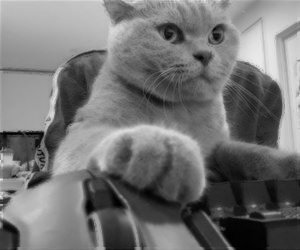

In [73]:
for B in range (1, 255, 50):
  for d in range (1, 4):
    startCPU = time()
    cpu = np.array(bileteral(img, B, d))
    print("Result CPU for B = {} and d = {}:".format(B, d))
    print("Performing CPU time {}".format(time()-startCPU))
    print("Visualization CPU:")
    cv2_imshow(cpu)

    startGPU = time()
    gpu = DeviceHost(img, B, d)
    print("Result GPU for B = {} and d = {}:".format(B, d))
    print("Performing GPU time {}".format(time()-startGPU))
    print("Visualization GPU:")
    cv2_imshow(gpu)
    print()